# Genes used in spatial aging clocks

This notebook determines the genes used for each of the cell type-specific spatial aging clocks and a supplementary table containing this information. It also generates GO term enrichment plots for these clock genes.

**Associated manuscript figures/tables:**
- Extended Data Figures: 5b,c
- Supplementary Table 10


**Inputs required:**
- `data/integrated_aging_coronal_celltyped_regioned_raw.h5ad` - AnnData object for coronal sections dataset
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock.py`)
- `results/pathway_enrichment/go_clock_coeffs_BP.xlsx` - spreadsheet containing GO enrichment results (generated from `go_analysis.R` and corresponds to Supplementary Table 12)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

## Clock genes

In [4]:
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")&(adata.obs.mouse_id!="89")&(adata.obs.mouse_id!="67")].copy()

In [7]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']


#######################
gene_names = adata.var_names
coefficients = []

for ct in celltypes:
        
    if f'{name}_{ct}.pkl' in os.listdir('results/clocks'): # if there exist clock for cell type
        
        # load and apply aging clock
        with open(f'results/clocks/{name}_{ct}.pkl', 'rb') as handle:
            pipeline = pickle.load(handle)
            
        coefficients.append(pipeline[1].coef_)
        
coefs_df = pd.DataFrame(np.vstack(coefficients), columns=gene_names, index=celltypes)

In [8]:
# Creates Supplementary Table
coefs_df.T.to_csv("supp_tables/TableS3_ClockCoefficients.csv")

# Heatmap of clock genes

In [3]:
coefs_df = pd.read_csv("supp_tables/TableS3_ClockCoefficients.csv", index_col=0)

In [5]:
# subset top clocks
coefs_df = coefs_df[restricted_celltype_subset]

In [12]:
# sort alphabetically
coefs_df = coefs_df.sort_index()

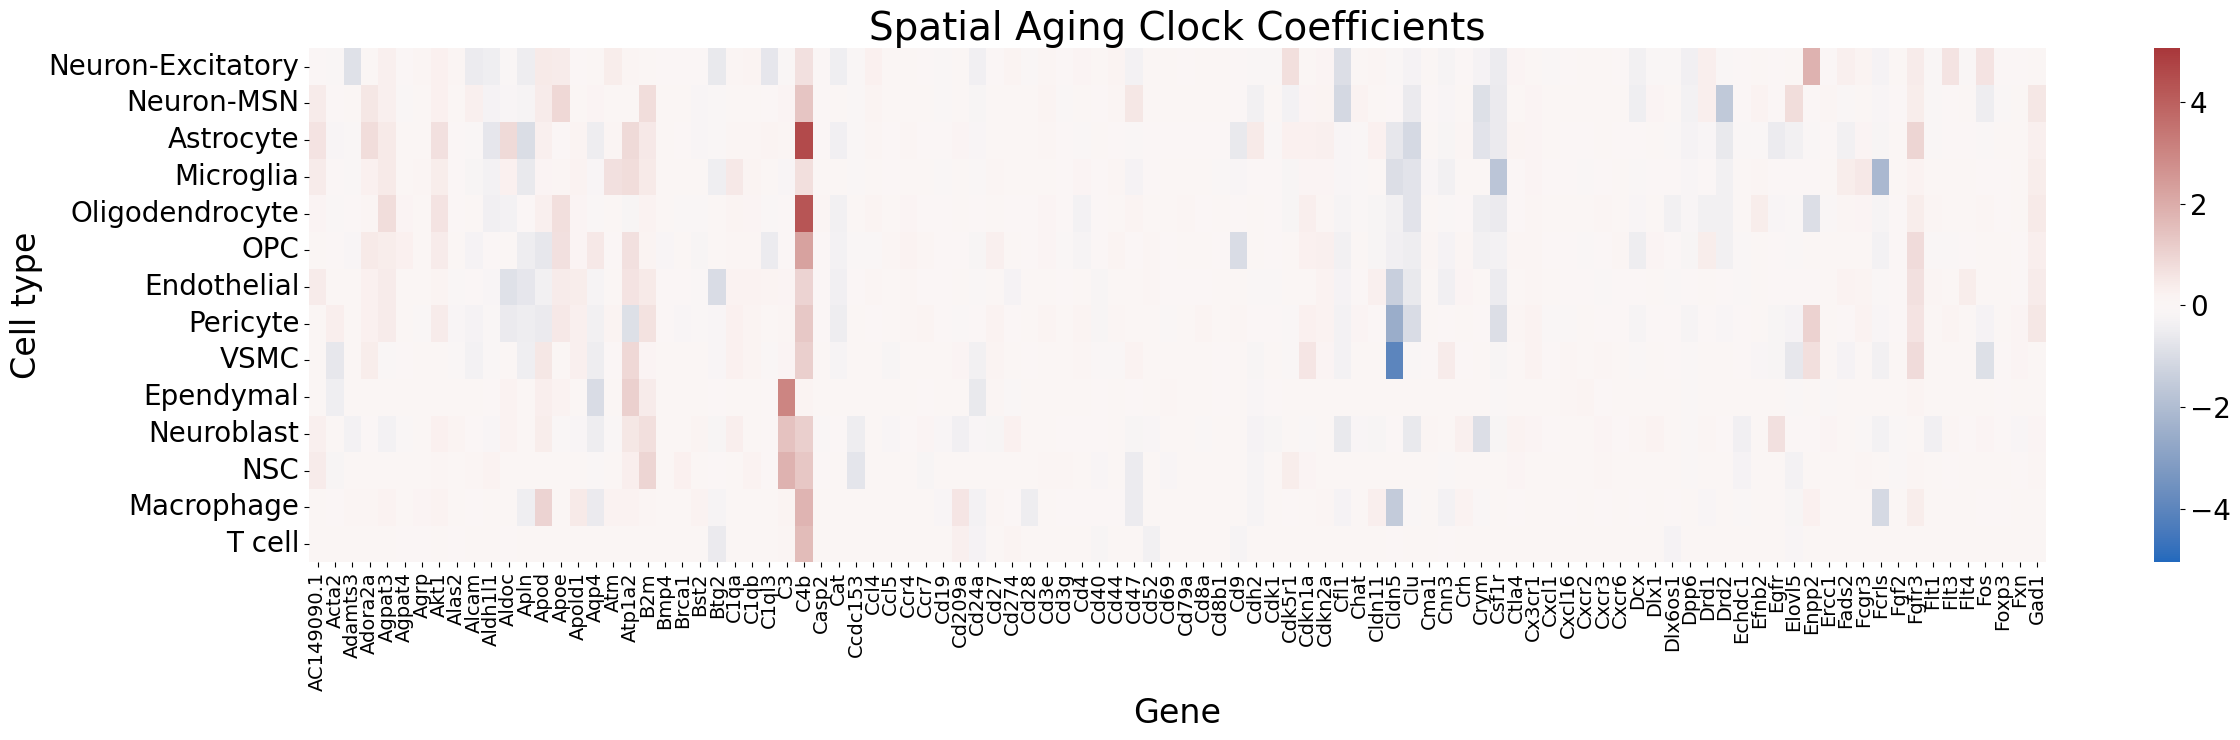

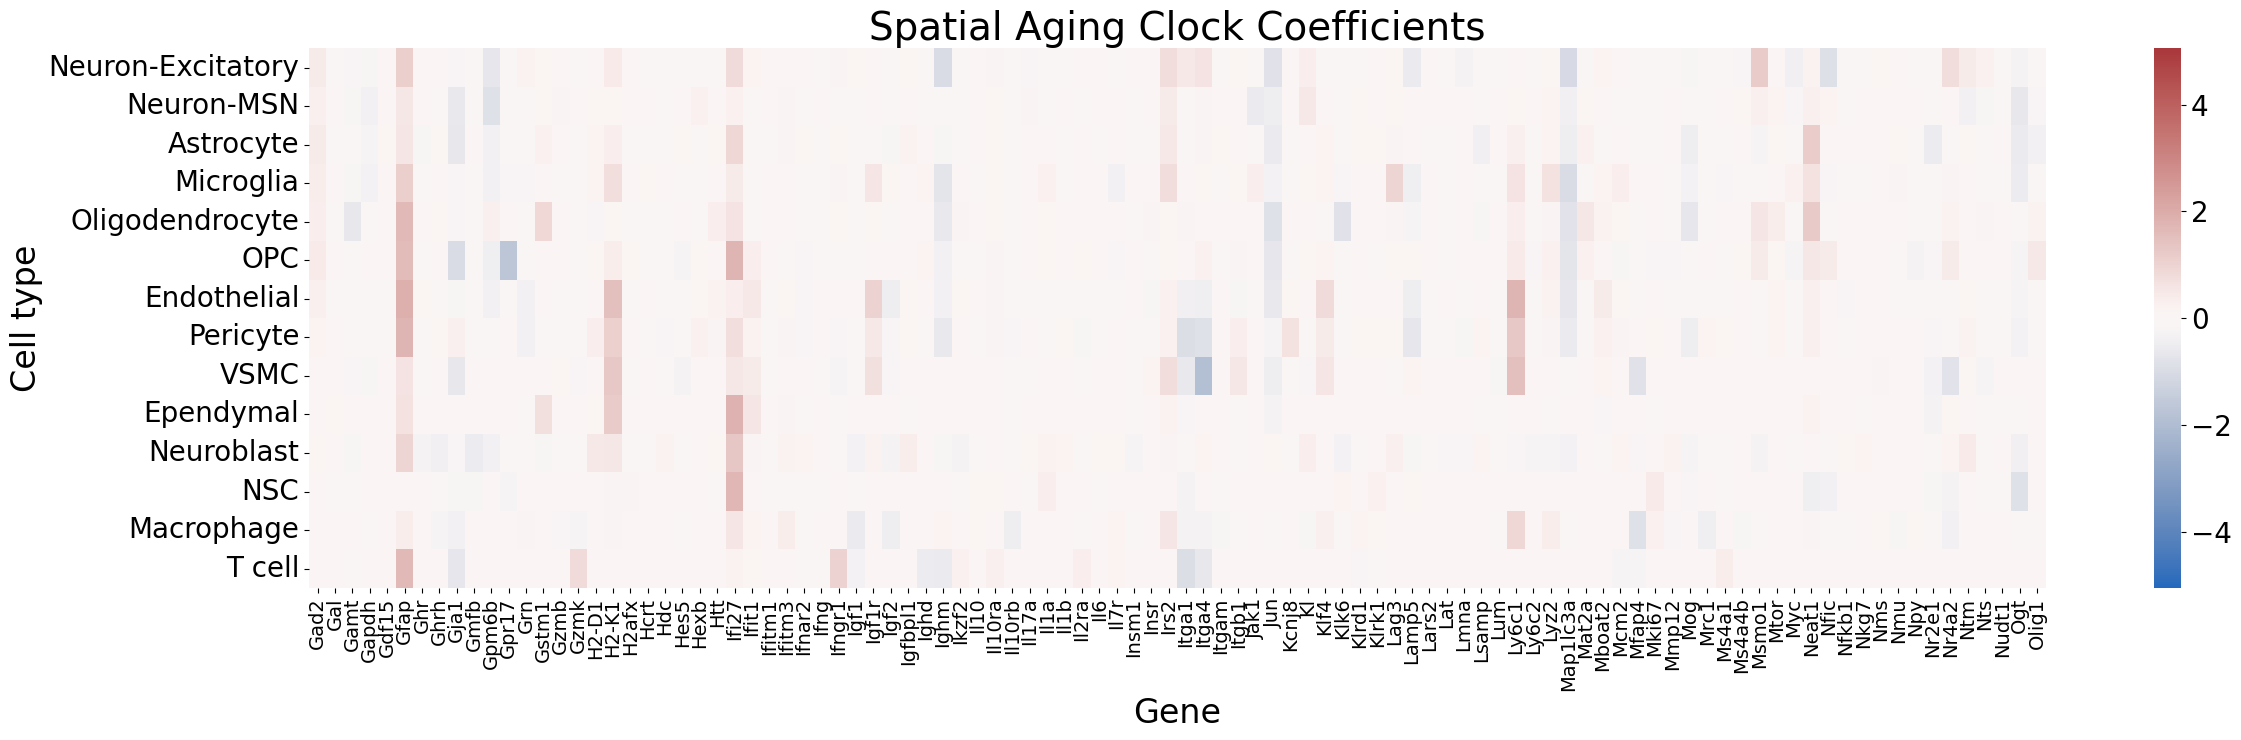

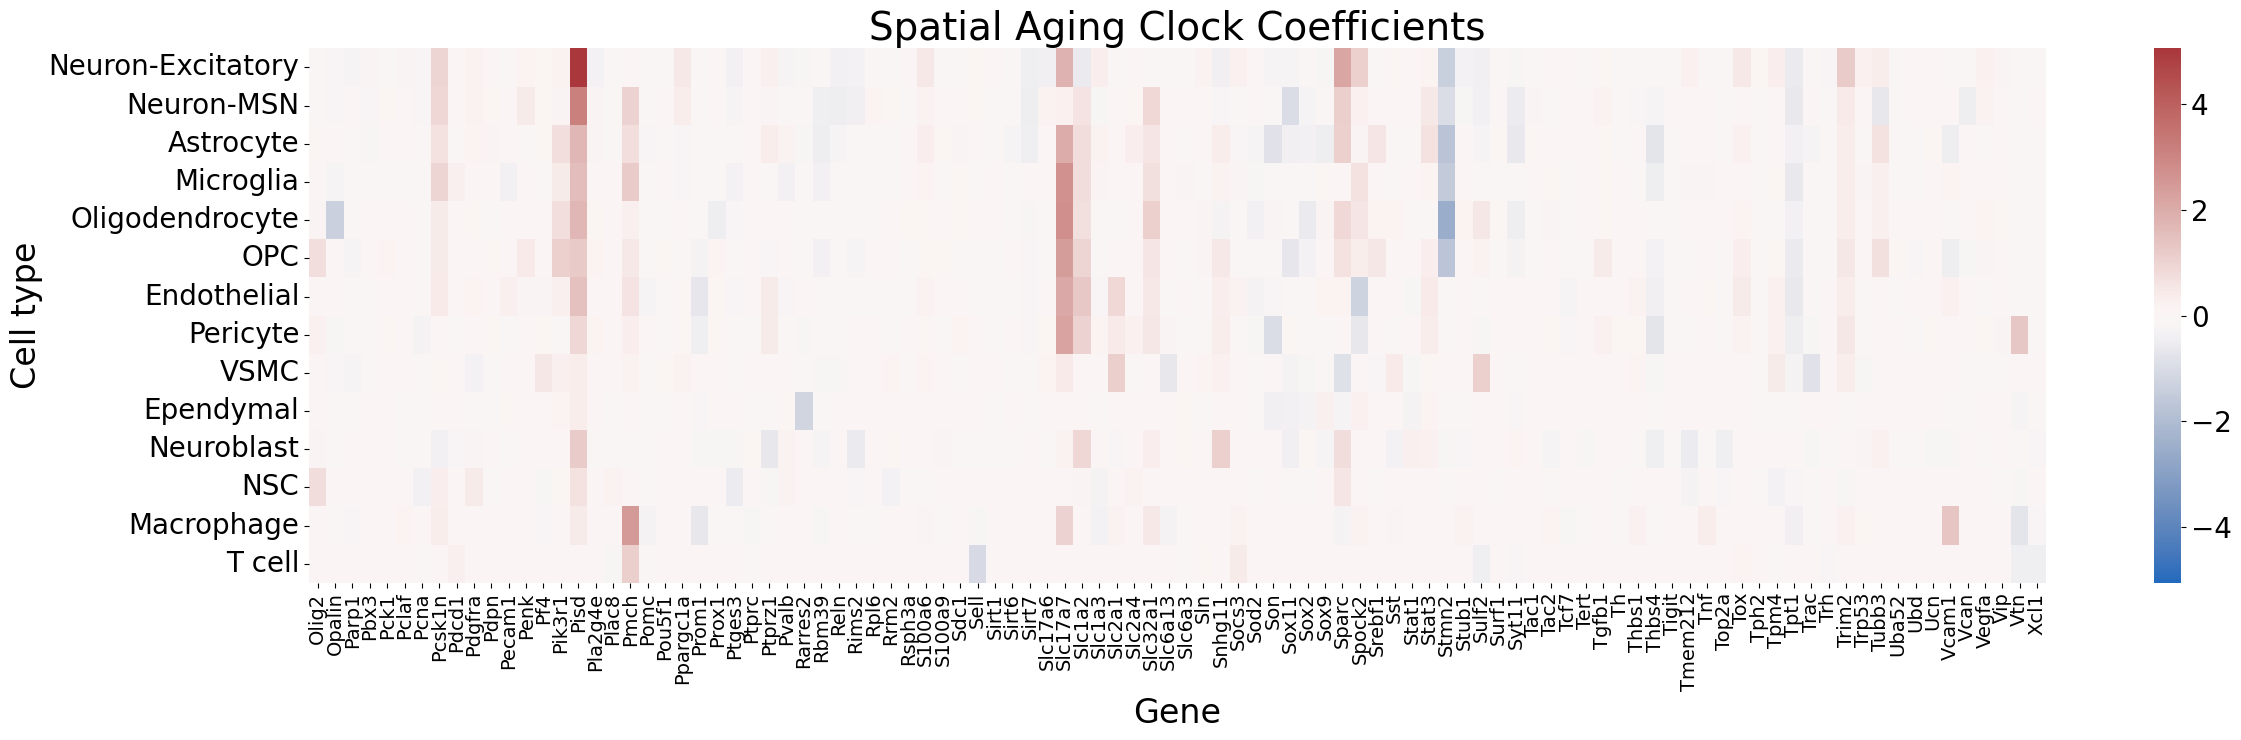

In [15]:
# heatmap plot transposed (stacked)
num_stacks = 3

stacks = np.split(coefs_df.T.columns, num_stacks)

for si in range(num_stacks):
    fig, ax = plt.subplots(figsize=(25,7.5))  
    g = sns.heatmap(coefs_df.T[stacks[si]], ax=ax,
                vmin=-np.max(np.abs(coefs_df.values.flatten())),
                vmax=np.max(np.abs(coefs_df.values.flatten())),
                cmap="vlag",  xticklabels=True, yticklabels=True)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
    g.collections[0].colorbar.ax.tick_params(labelsize=20)
    plt.xlabel("Gene", fontsize=24)
    plt.ylabel("Cell type", fontsize=24)
    plt.title("Spatial Aging Clock Coefficients", fontsize=28)
    plt.tight_layout()
    plt.savefig(f"plots/clocks/coefficient_heatmap_transpose_stack{si}.pdf",
              bbox_inches='tight')
    plt.show()

# Pathway Enrichment Plot

In [3]:
# read in Excel results
df_dict = pd.read_excel("results/pathway_enrichment/go_clock_coeffs_BP.xlsx",
                   sheet_name=None)

In [5]:
# go through sheets and collect into one dataframe

top_n = 3

top_df_list = []
df_list = []

for sheet in df_dict.keys():
    if sheet.split("_")[0] in restricted_celltype_subset:
        sdf = df_dict[sheet]
        sdf["celltype"] = sheet.split("_")[0]
        sdf["coef"] = sheet.split("_")[1]
        sdf["neglog10Fisher"] = -np.log10(sdf["Fisher"])
        sdf = sdf.sort_values(by="Fisher")
        top_df_list.append(sdf.head(top_n))
        df_list.append(sdf)

top_df = pd.concat(top_df_list)
df = pd.concat(df_list)

# reorder cell types
celltype_order = restricted_celltype_subset

top_df["celltype"] = top_df["celltype"].astype('category').cat.reorder_categories(celltype_order)
top_df = top_df.sort_values(by=["celltype","Fisher"])

df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltype_order)
df = df.sort_values(by=["celltype","Fisher"])

/local/scratch/edsun/slrmtmp.43147004/ipykernel_2377/536972594.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = sub_df.pivot("Term", "celltype", "neglog10Fisher")
/local/scratch/edsun/slrmtmp.43147004/ipykernel_2377/536972594.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


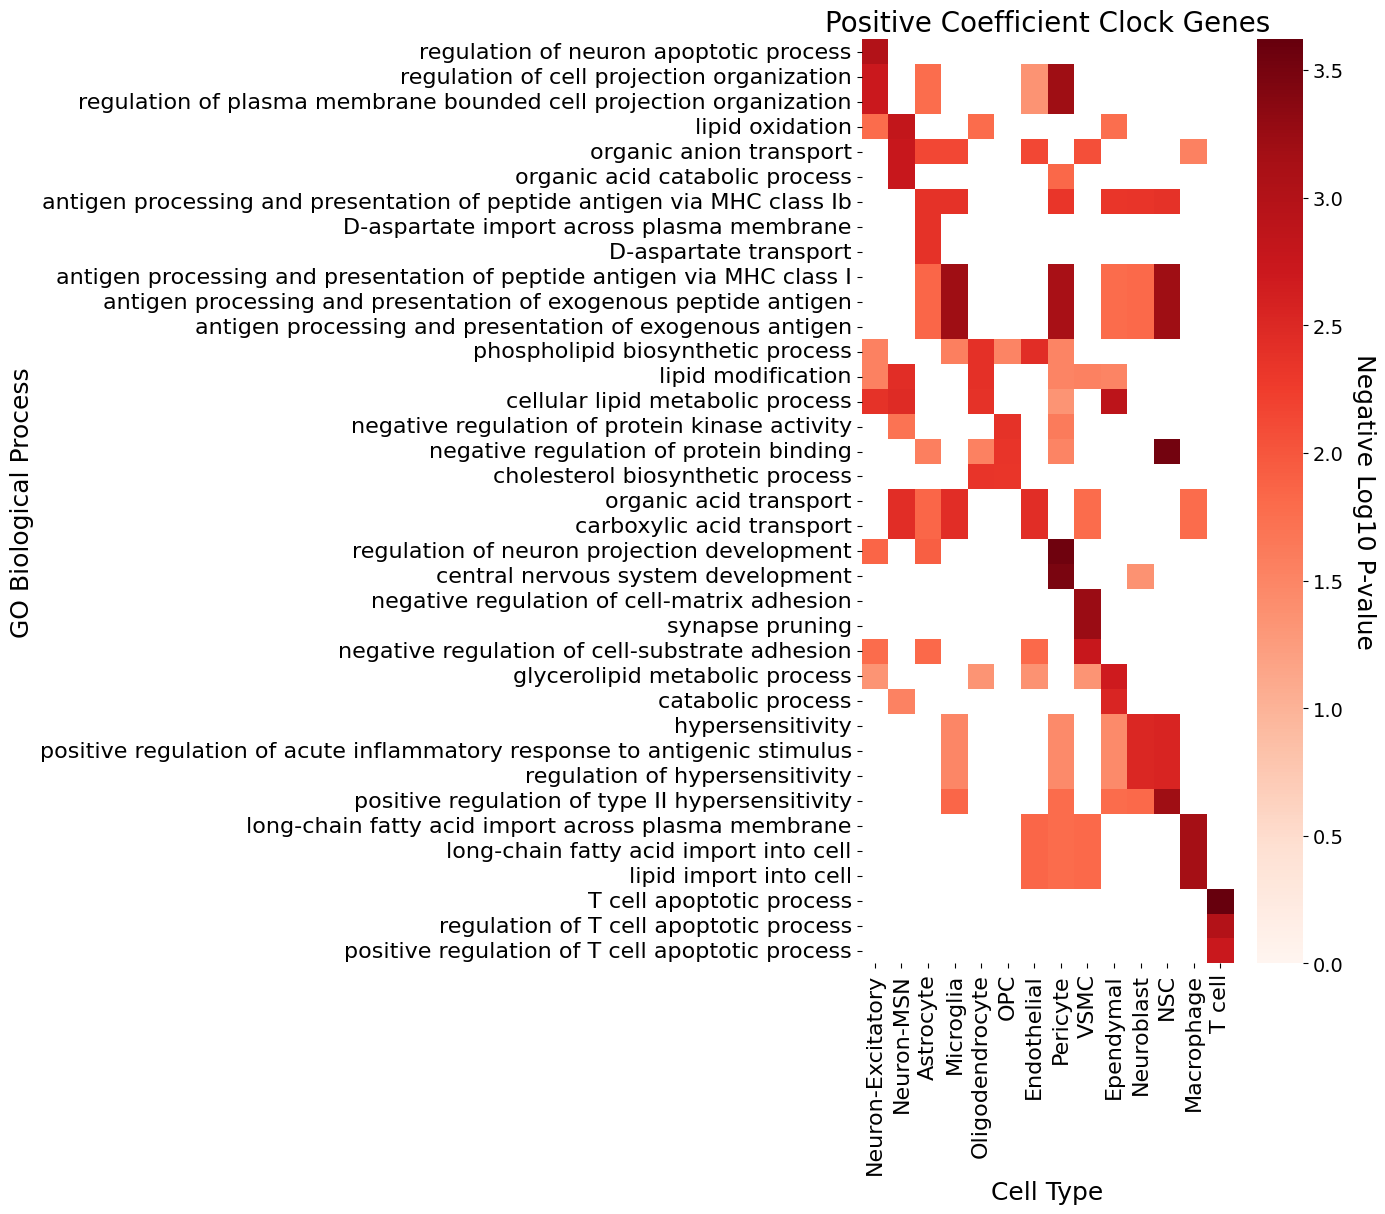

In [6]:
# Increasing only

sub_top_df = top_df[top_df["coef"]=="increasing"]
sub_df = df[df["coef"]=="increasing"]

#-----------------------------------------

# subset only top terms
top_terms = sub_top_df["Term"].values
sub_df = sub_df[sub_df["Term"].isin(top_terms)]
sub_df["Term"] = sub_df["Term"].astype('category').cat.reorder_categories(pd.unique(top_terms))

pivot_df = sub_df.pivot("Term", "celltype", "neglog10Fisher")


# PLOT

fig, ax = plt.subplots(figsize=(6,12))

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=False, cmap="Reds", vmin=0)

ax.collections[0].colorbar.set_label('Negative Log10 P-value',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title("Positive Coefficient Clock Genes", fontsize=20)
plt.ylabel("GO Biological Process", fontsize=18)
plt.xlabel("Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/pathways/positive_clock_genes.pdf",
          bbox_inches='tight')
plt.show()

/local/scratch/edsun/slrmtmp.43147004/ipykernel_2377/2655284408.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = sub_df.pivot("Term", "celltype", "neglog10Fisher")
/local/scratch/edsun/slrmtmp.43147004/ipykernel_2377/2655284408.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


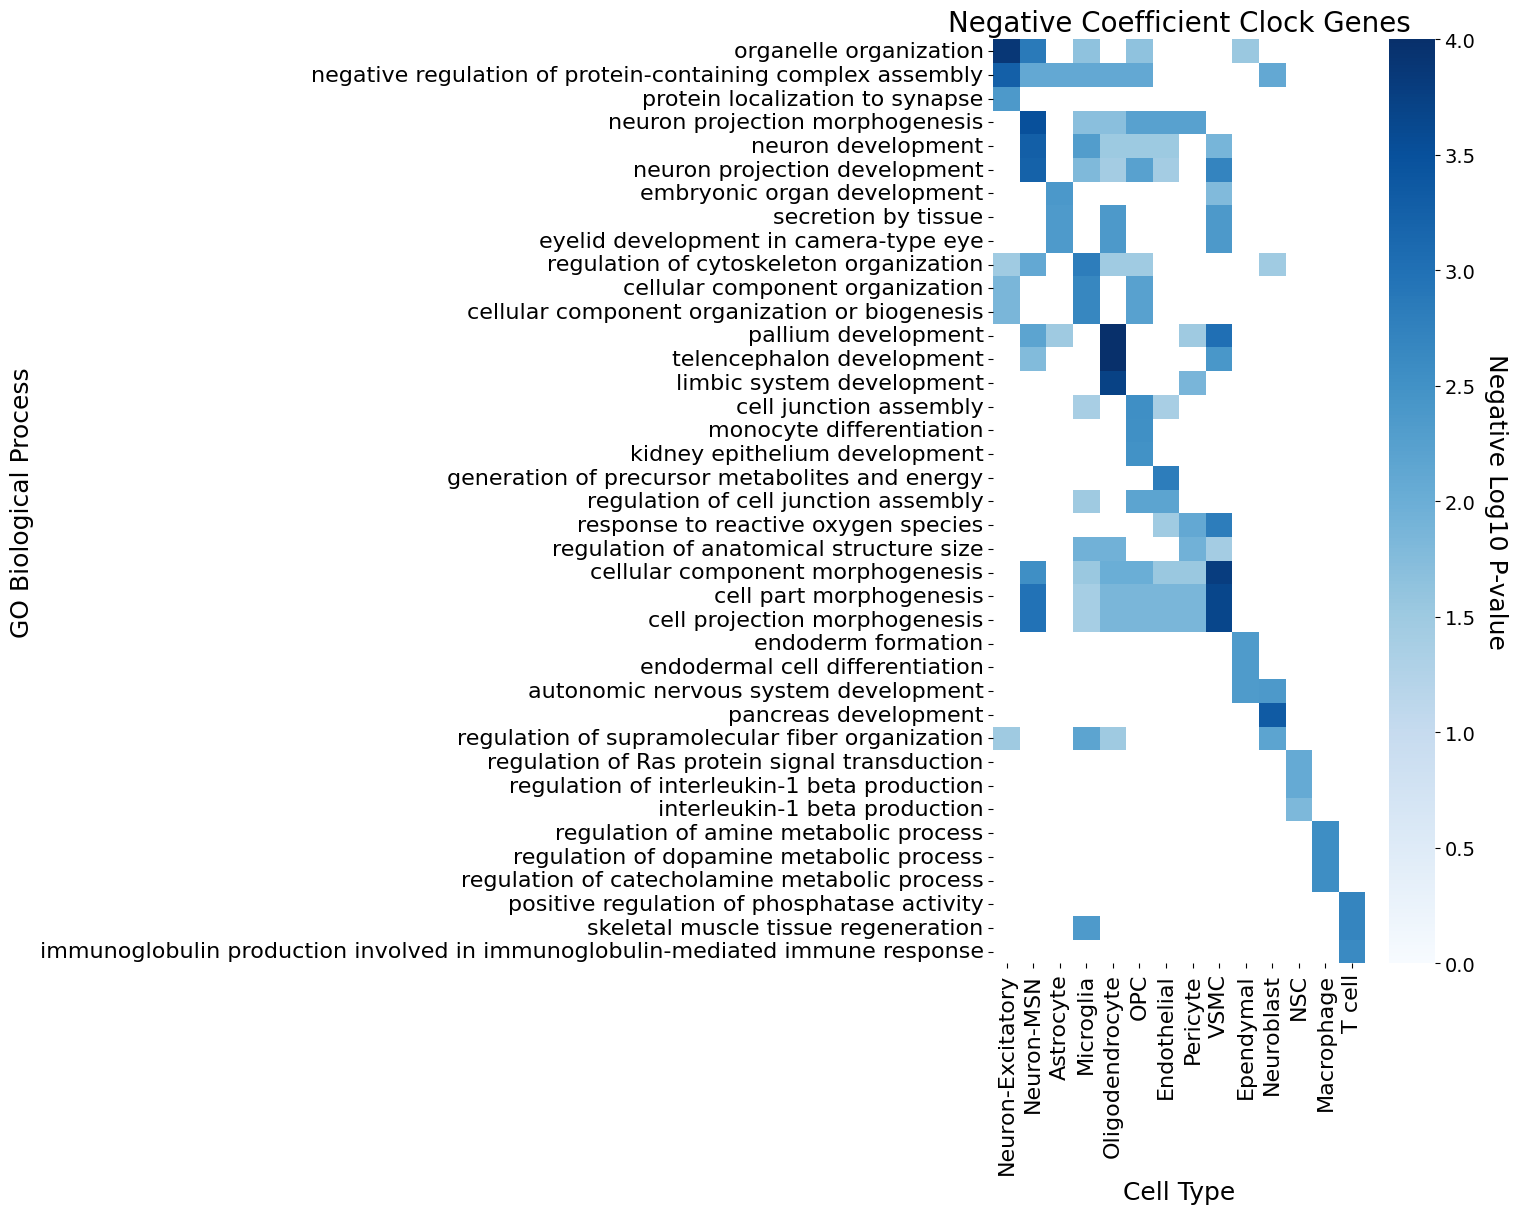

In [7]:
# Decreasing only

sub_top_df = top_df[top_df["coef"]=="decreasing"]
sub_df = df[df["coef"]=="decreasing"]

#-----------------------------------------

# subset only top terms
top_terms = sub_top_df["Term"].values
sub_df = sub_df[sub_df["Term"].isin(top_terms)]
sub_df["Term"] = sub_df["Term"].astype('category').cat.reorder_categories(pd.unique(top_terms))

pivot_df = sub_df.pivot("Term", "celltype", "neglog10Fisher")


# PLOT

fig, ax = plt.subplots(figsize=(6,12))

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=False, cmap="Blues", vmin=0)

ax.collections[0].colorbar.set_label('Negative Log10 P-value',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title("Negative Coefficient Clock Genes", fontsize=20)
plt.ylabel("GO Biological Process", fontsize=18)
plt.xlabel("Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/pathways/negative_clock_genes.pdf",
          bbox_inches='tight')
plt.show()